#### selecting low flow without snow

In [16]:
import pandas as pd
import glob
import os
from utils import read_fmi_meteo_obs

<Axes: xlabel='time'>

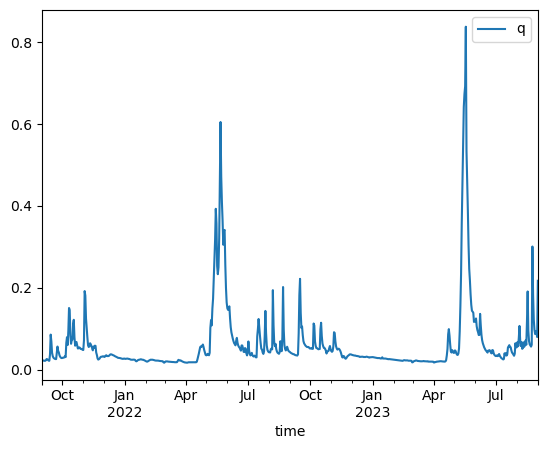

In [31]:
# Path to the directory containing the files
data_dir = r'/Users/jpnousu/DTS_data/AUX_DATA/'

# Find all relevant files (assuming they all start with 'Pallas_V-weir_hourly_')
files = sorted(glob.glob(os.path.join(data_dir, 'Pallas_V-weir_hourly_*.txt')))

# Read and combine all files
dfs = []
for file in files:
    q = pd.read_csv(file, skiprows=5, sep=';', parse_dates=[['date', ' time_UTC']], index_col=0)
    q = q.rename_axis('time')
    q.columns = q.columns.str.strip()  # Strip spaces from column names
    q = q.rename(columns={'Discharge': 'q'})
    q['q'] = q['q'].astype(float)
    dfs.append(q)

# Combine into a single DataFrame
q_all = pd.concat(dfs)
q_all = q_all.resample('D').mean()
q_all.loc[slice('2021-09-01', '2023-09-01')].plot()

In [5]:
file_snow = r'/Users/jpnousu/DTS_data/AUX_DATA/HS_Kittilä Kenttärova_ 1.7.2021 - 11.2.2025_6c68dab8-cbf1-4861-aa42-50a9ac38a15a.csv'

In [32]:
hs = pd.read_csv(file_snow)
hs['time'] = pd.to_datetime(hs[['Vuosi', 'Kuukausi', 'Päivä']].astype(str).agg('-'.join, axis=1) + ' ' + hs['Aika [Paikallinen aika]'])
hs.set_index('time', inplace=True)
hs.drop(columns=['Vuosi', 'Kuukausi', 'Päivä', 'Aika [Paikallinen aika]', 'Havaintoasema'], inplace=True)
hs = hs.rename(columns={'Lumensyvyys [cm]': 'HS'})
hs['HS'] = pd.to_numeric(hs['HS'], errors='coerce')
hs.loc[hs['HS'] < 0, 'HS'] = 0
hs = hs/100
hs = hs.resample('D').mean()

In [40]:
meteo_file1 = r'/Users/jpnousu/DTS_data/AUX_DATA/Kittilä Kenttärova_ 1.7.2021 - 2.9.2024_c07c2c96-089c-4173-9cd0-e58fe8386405.csv'
meteo1 = read_fmi_meteo_obs(filename=meteo_file1, resample='30MIN')
#meteo1 = meteo1.resample('D').mean()

#### Finding time period with low flow, before snow and when there's large diurnal temperature variability

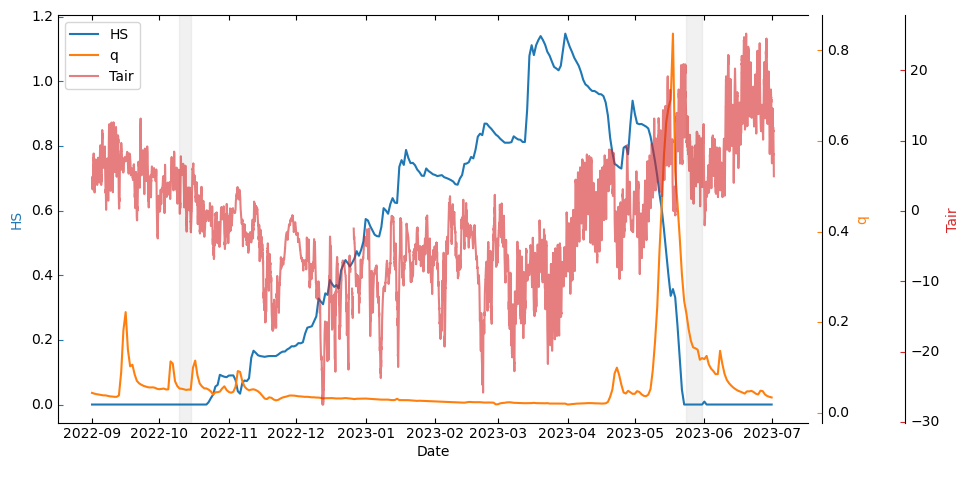

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import pandas as pd

# Define date range for plotting
start = '2022-09-01'
end = '2023-07-01'

# Slice the dataframes
hs_range = hs.loc[start:end]
q_range = q_all.loc[start:end]
tair_range = meteo1.loc[start:end]

# Create host subplot
fig = plt.figure(figsize=(12, 6))
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

# Create parasite axes
par1 = host.twinx()
par2 = host.twinx()

# Offset the third axis (Tair)
offset = 70
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2, offset=(offset, 0))
par2.axis["right"].toggle(all=True)

# Offset the second axis (q)
offset2 = 10
new_fixed_axis_2 = par1.get_grid_helper().new_fixed_axis
par1.axis["right"] = new_fixed_axis_2(loc="right", axes=par1, offset=(offset2, 0))
par1.axis["right"].toggle(all=True)

# Colors
color_hs = 'tab:blue'
color_q = 'tab:orange'
color_tair = 'tab:red'

# Plot each dataset
p1, = host.plot(hs_range.index, hs_range['HS'], color=color_hs, label='HS')
p2, = par1.plot(q_range.index, q_range['q'], color=color_q, label='q')
p3, = par2.plot(tair_range.index, tair_range['Tair'], color=color_tair, label='Tair', alpha=0.6)

# Axis labels
host.set_xlabel("Date")
host.set_ylabel("HS", color=color_hs)
par1.set_ylabel("q", color=color_q)
par2.set_ylabel("Tair", color=color_tair)

# Tick and label colors
host.axis["left"].label.set_color(color_hs)
par1.axis["right"].label.set_color(color_q)
par2.axis["right"].label.set_color(color_tair)

host.tick_params(axis='y', colors=color_hs)
par1.tick_params(axis='y', colors=color_q)
par2.tick_params(axis='y', colors=color_tair)

# Highlight time periods
highlight_periods = [
    ('2022-10-10', '2022-10-15'),
    ('2023-05-24', '2023-05-31'),
]
for hstart, hend in highlight_periods:
    host.axvspan(pd.to_datetime(hstart), pd.to_datetime(hend), color='lightgrey', alpha=0.3)

# Format x-axis
fig.autofmt_xdate()

# Add legend
lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines])

plt.show()
